In [2]:
import geopandas as gpd
from pathlib import Path
import matplotlib.pyplot as plt
import contextily as cx
import fiona 
import numpy as np
# Potentiel solaire package
from potentiel_solaire.constants import DATA_FOLDER

In [3]:
# Verification des layers disponibles
stdenis_path = DATA_FOLDER / "saint_denis_reference_data.gpkg"
layers = fiona.listlayers(stdenis_path)
print(" ".join(layers))

annuaire_education bdtopo_education bdtopo_batiment cadastre_parcellaire potentielsolaire_bati potentielsolaire_toitures identifiers


## On ouvre le jeu de données préparé

In [4]:
# On ouvre une zone
ID = 6
stdenis = gpd.read_file(stdenis_path, layer="bdtopo_education")# toponymie_services_et_activites
stdenis = stdenis.to_crs(2154) # 2154 Lambert, 4326 latlon  
example = stdenis[ID:ID+1]
ID = example["cleabs_left"].iloc[0]
NOM = example["toponyme"].iloc[0]
# On ouvre les toitures
toiture = gpd.read_file(stdenis_path, layer="bdtopo_batiment")# toponymie_services_et_activites
toiture = toiture.to_crs(2154) # 2154 Lambert, 4326 latlon  
toiture = gpd.sjoin(toiture, example, how='inner', predicate='within',lsuffix='_l', rsuffix='_r')

/tmp/ipykernel_201914/1844895196.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


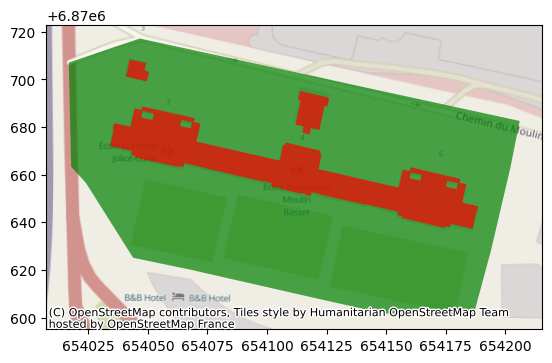

In [5]:
fig, ax = plt.subplots()

example.plot(ax=ax, alpha=0.7, color ="green")
toiture.plot(ax=ax, alpha=0.7, color ="red")

cx.add_basemap(ax, crs=example.crs)
fig.show()

# Exploration MNS liées aux zones

In [6]:
import rasterio
import rasterio.mask
import os
from rasterio.plot import show

## On recadre l'image

In [7]:
geotiff_cached = "../data/cache/mns/"+ID+".masked.tif"

if not os.path.isfile(geotiff_cached):
    geome = example.geometry.total_bounds
    A = "0"+str(int(geome[0]//1000))
    B = str(int(geome[1]//1000)+1)
    tile = "/MNS-Correl_1-0__TIFF_LAMB93_D093_2024-01-01/MNS-Correl/1_DONNEES_LIVRAISON_2024-11-00179/MNS-C_0M50_TIF_LAMB93_D93-2024/93-2024-"+A+"-"+B+"-LA93-0M50.tif"
    path = DATA_FOLDER / tile
    with rasterio.open("../data/"+str(path)) as img:
        out_image, out_transform = rasterio.mask.mask(img, example.geometry, crop=True)
        out_meta = img.meta
    minval = np.min(out_image[np.nonzero(out_image)])
    out_image = out_image - minval

    out_image = np.where(out_image<0, 0, out_image)
    out_meta.update({"driver": "GTiff",
                    "height": out_image.shape[1],
                    "width": out_image.shape[2],
                    "transform": out_transform})

    with rasterio.open("../data/cache/mns/"+ID+".masked.tif", "w", **out_meta) as dest:
        dest.write(out_image)

## Et on la représente

/tmp/ipykernel_201914/783071908.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


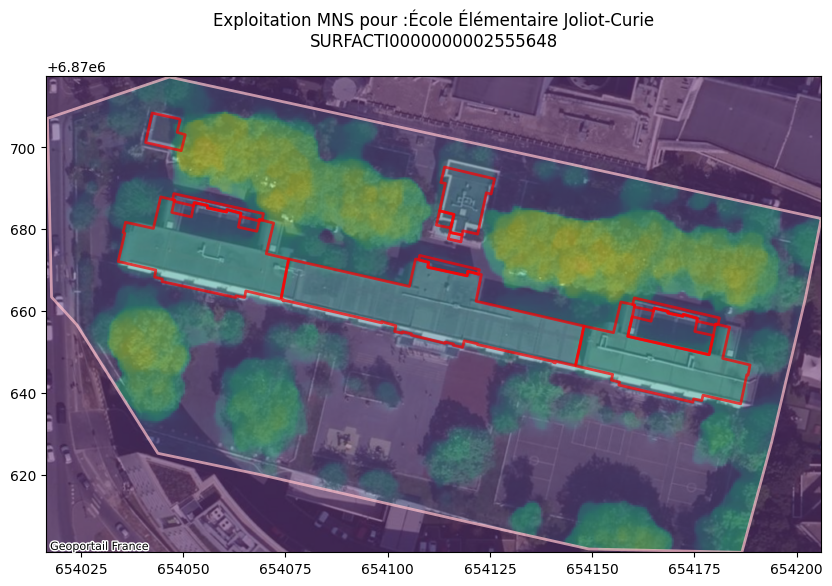

In [8]:
img_ecole = rasterio.open("../data/cache/mns/"+ID+".masked.tif")

fig, ax = plt.subplots(figsize=(10,10))



show(img_ecole, ax=ax, alpha=0.9)
example.plot(ax=ax, alpha=0.7, linewidth=2, facecolor="none", edgecolor='pink')
toiture.plot(ax=ax, alpha=0.7, linewidth=2,facecolor="none", edgecolor='red')

cx.add_basemap(ax, crs=example.crs, alpha=0.5, source=cx.providers.GeoportailFrance.orthos )

plt.title("Exploitation MNS pour :"+ NOM+"\n"+ID+"\n")
fig.show()



# Focalisation sur les batiments

In [9]:
geotiff_cached_toits = "../data/cache/mns/"+ID+"_toits.masked.tif"

if not os.path.isfile(geotiff_cached_toits) or True:
    geome = example.geometry.total_bounds
    A = "0"+str(int(geome[0]//1000))
    B = str(int(geome[1]//1000)+1)
    tile = "/MNS-Correl_1-0__TIFF_LAMB93_D093_2024-01-01/MNS-Correl/1_DONNEES_LIVRAISON_2024-11-00179/MNS-C_0M50_TIF_LAMB93_D93-2024/93-2024-"+A+"-"+B+"-LA93-0M50.tif"
    path = DATA_FOLDER / tile
    with rasterio.open("../data/"+str(path)) as img:
        out_image, out_transform = rasterio.mask.mask(img, toiture.geometry, crop=True)
        out_meta = img.meta
    minval = np.min(out_image[np.nonzero(out_image)])
    out_image = out_image - minval

    out_image = np.where(out_image<0, 0, out_image)

    MAX = np.percentile(out_image[np.nonzero(out_image)],80)
    out_image = np.where(out_image>=MAX, MAX, out_image)

    out_meta.update({"driver": "GTiff",
                    "height": out_image.shape[1],
                    "width": out_image.shape[2],
                    "transform": out_transform})

    with rasterio.open(geotiff_cached_toits, "w", **out_meta) as dest:
        dest.write(out_image)

/tmp/ipykernel_201914/1014431379.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


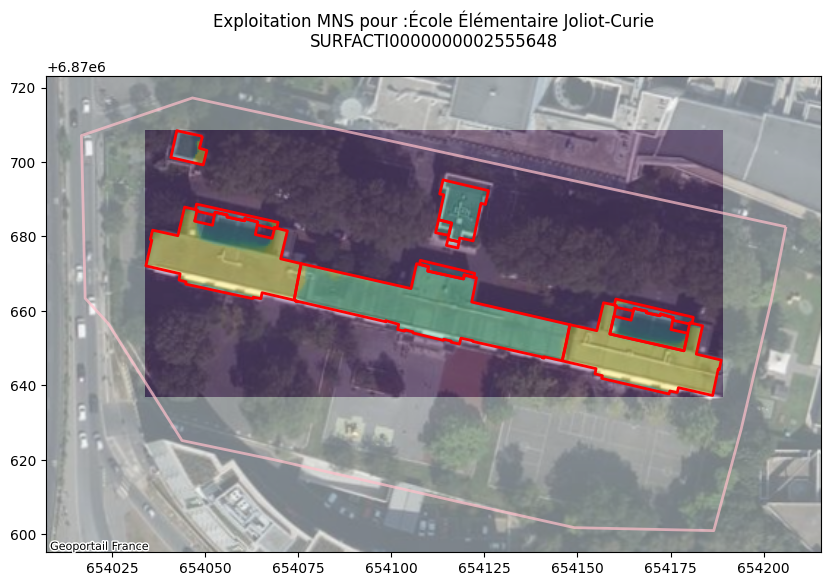

In [10]:
img_ecole = rasterio.open(geotiff_cached_toits)

fig, ax = plt.subplots(figsize=(10,10))

show(img_ecole, ax=ax, alpha=0.8)

example.plot(ax=ax, alpha=0.7, linewidth=2, facecolor="none", edgecolor='pink')
# A explorer peut etre: cx.providers.GeoportailFrance 
cx.add_basemap(ax, crs=example.crs, alpha=0.6, source=cx.providers.GeoportailFrance.orthos )
toiture.plot(ax=ax, alpha=1, linewidth=2,facecolor="none", edgecolor='red')


plt.title("Exploitation MNS pour :"+ NOM+"\n"+ID+"\n")
fig.show()

# Et sur toutes les écoles

In [13]:
stdenis = gpd.read_file(stdenis_path, layer="bdtopo_education")# toponymie_services_et_activites
toiture_full = gpd.read_file(stdenis_path, layer="bdtopo_batiment")# toponymie_services_et_activites
stdenis = stdenis.to_crs(2154) # 2154 Lambert, 4326 latlon  
toiture_full = toiture_full.to_crs(2154) # 2154 Lambert, 4326 latlon  

In [41]:
OnVeutRefaireTousLesToits = False
if OnVeutRefaireTousLesToits:
    for ID in range(len(stdenis)-1):
        example = stdenis[ID:ID+1]
        ID = example["cleabs_left"].iloc[0]
        NOM = example["toponyme"].iloc[0]
        print(ID)
        toiture = gpd.sjoin(toiture_full, example, how='inner', predicate='within',lsuffix='_l', rsuffix='_r')

        geotiff_cached = "../data/cache/mns/"+ID+".masked.tif"
        try:

            if not os.path.isfile(geotiff_cached):
                geome = example.geometry.total_bounds
                A = "0"+str(int(geome[0]//1000))
                B = str(int(geome[1]//1000)+1)
                tile = "/MNS-Correl_1-0__TIFF_LAMB93_D093_2024-01-01/MNS-Correl/1_DONNEES_LIVRAISON_2024-11-00179/MNS-C_0M50_TIF_LAMB93_D93-2024/93-2024-"+A+"-"+B+"-LA93-0M50.tif"
                path = DATA_FOLDER / tile
                with rasterio.open("../data/"+str(path)) as img:
                    out_image, out_transform = rasterio.mask.mask(img, example.geometry, crop=True)
                    out_meta = img.meta
                minval = np.min(out_image[np.nonzero(out_image)])
                out_image = out_image - minval

                out_image = np.where(out_image<0, 0, out_image)
                out_meta.update({"driver": "GTiff",
                                "height": out_image.shape[1],
                                "width": out_image.shape[2],
                                "transform": out_transform})

                with rasterio.open("../data/cache/mns/"+ID+".masked.tif", "w", **out_meta) as dest:
                    dest.write(out_image)


            geotiff_cached_toits = "../data/cache/mns/"+ID+"_toits.masked.tif"

            if not os.path.isfile(geotiff_cached_toits) or True:
                geome = example.geometry.total_bounds
                A = "0"+str(int(geome[0]//1000))
                B = str(int(geome[1]//1000)+1)
                tile = "/MNS-Correl_1-0__TIFF_LAMB93_D093_2024-01-01/MNS-Correl/1_DONNEES_LIVRAISON_2024-11-00179/MNS-C_0M50_TIF_LAMB93_D93-2024/93-2024-"+A+"-"+B+"-LA93-0M50.tif"
                path = DATA_FOLDER / tile
                with rasterio.open("../data/"+str(path)) as img:
                    out_image, out_transform = rasterio.mask.mask(img, toiture.geometry, crop=True)
                    out_meta = img.meta
                minval = np.min(out_image[np.nonzero(out_image)])
                out_image = out_image - minval

                out_image = np.where(out_image<0, 0, out_image)

                MAX = np.percentile(out_image[np.nonzero(out_image)],80)
                out_image = np.where(out_image>=MAX, MAX, out_image)

                out_meta.update({"driver": "GTiff",
                                "height": out_image.shape[1],
                                "width": out_image.shape[2],
                                "transform": out_transform})

                with rasterio.open(geotiff_cached_toits, "w", **out_meta) as dest:
                    dest.write(out_image)


            img_ecole = rasterio.open(geotiff_cached_toits)

            fig, ax = plt.subplots(figsize=(10,10))

            show(img_ecole, ax=ax, alpha=0.8)

            example.plot(ax=ax, alpha=0.7, linewidth=2, facecolor="none", edgecolor='pink')
            # A explorer peut etre: cx.providers.GeoportailFrance 
            cx.add_basemap(ax, crs=example.crs, alpha=0.6, source=cx.providers.GeoportailFrance.orthos )
            toiture.plot(ax=ax, alpha=1, linewidth=2,facecolor="none", edgecolor='red')


            plt.title("Exploitation MNS pour :"+ NOM+"\n"+ID+"\n")
            plt.savefig("../data/cache/mns/jpg/"+ID+".jpg", bbox_inches='tight')
            #fig.show()
        except:
            print("Error with",ID)